In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim


from nltk.corpus import stopwords

from collections import Counter

import string

import re

import seaborn as sns

from tqdm import tqdm

import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords

import time

In [ ]:
!python -m nltk.downloader stopwords


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
!unzip /content/drive/MyDrive/movie-sentiment.zip

Archive:  /content/drive/MyDrive/movie-sentiment.zip
  inflating: IMDB Dataset.csv        


In [ ]:
!du -sh /content/IMDB-Dataset.csv

64M	/content/IMDB-Dataset.csv


#Dataset Preprocess

In [ ]:
base_csv = '/content/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
print(df)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [ ]:
X,y = df['review'].values,df['sentiment'].values


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)


In [ ]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [ ]:
x_train,y_train,x_test,y_test,vocab = tokenize( x_train,y_train,x_test,y_test)


<ipython-input-18-a9faa483b6b9>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [ ]:
print(f'Length of vocabulary is {len(vocab)}')


Length of vocabulary is 1000


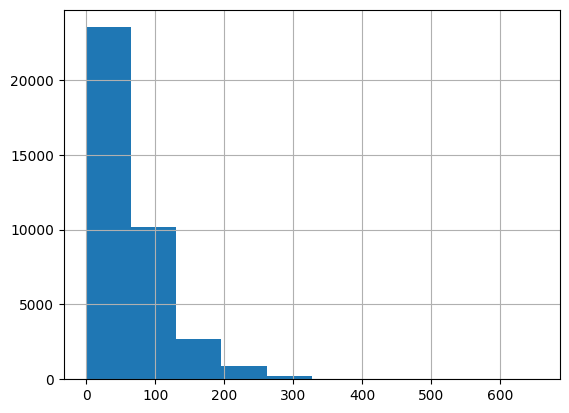

count    37500.000000
mean        69.136533
std         48.132951
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        653.000000
dtype: float64

In [ ]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [ ]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 145, 142,  23],
        [  0,   0,   0,  ...,   7, 445, 737],
        [  0,   0,   0,  ...,   2, 518, 283],
        ...,
        [  0,   0,   0,  ..., 658,  16,   2],
        [  0,   0,   0,  ...,  26,  29, 213],
        [  0,   0,   0,  ..., 113, 911,  20]])
Sample input: 
 tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1])


#LSTM model def

In [ ]:
class LSTM(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(LSTM,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
         # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden



    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [ ]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = LSTM(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

LSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


#GRU model def

In [ ]:
class GRU(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.5):
        super(GRU, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and GRU layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=self.hidden_dim,
                          num_layers=no_layers, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        # embeddings and gru_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        gru_out, hidden = self.gru(embeds, hidden)

        gru_out = gru_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(gru_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1]  # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create a new tensor with size n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state of GRU
        h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        hidden = h0
        return hidden

    # def init_hidden(self, batch_size):
    #     ''' Initializes hidden state '''
    #     # Create a new tensor with size no_layers x batch_size x hidden_dim,
    #     # initialized to zero, for hidden state of GRU
    #     h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
    #     return h0

In [ ]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 2
hidden_dim = 256


model = GRU(no_layers,vocab_size,hidden_dim,embedding_dim,output_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

GRU(
  (embedding): Embedding(1001, 64)
  (gru): GRU(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (sig): Sigmoid()
)


#model stats

In [ ]:
!pip install thop

In [ ]:
from thop import profile

vocab_size = 1001
sequence_length = 10
batch_size = 32

hidden_state = torch.zeros(2, batch_size, 256).to(device)

input = torch.randint(0, vocab_size, (batch_size, sequence_length)).to(device)
macs, params = profile(model, inputs=(input, hidden_state))

print('\nNumber of parameters:', params, '\nNumber of computations for a forward pass:', macs)

[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.

Number of parameters: 642562.0 
Number of computations for a forward pass: 413532160.0


#criterion, optim

In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
# criterion = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

#train loop for LSTM

In [ ]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    t0 = time.time()
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
            epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print('\nEpoch time: {} seconds'.format(time.time() - t0))
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '/content/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.6935047012964884 val_loss : 0.6934361908435821
train_accuracy : 49.95733333333333 val_accuracy : 49.992

Epoch time: 57.537819385528564 seconds
Validation loss decreased (inf --> 0.693436).  Saving model ...
Epoch 2
train_loss : 0.6933213901519776 val_loss : 0.6933018074035645
train_accuracy : 50.029333333333334 val_accuracy : 50.064

Epoch time: 60.12114644050598 seconds
Validation loss decreased (0.693436 --> 0.693302).  Saving model ...
Epoch 3
train_loss : 0.6932621578375499 val_loss : 0.6932038626670838
train_accuracy : 50.0 val_accuracy : 50.048

Epoch time: 60.0056517124176 seconds
Validation loss decreased (0.693302 --> 0.693204).  Saving model ...
Epoch 4
train_loss : 0.693245634873708 val_loss : 0.6931245911121369
train_accuracy : 50.029333333333334 val_accuracy : 50.160000000000004

Epoch time: 60.10469126701355 seconds
Validation loss decreased (0.693204 --> 0.693125).  Saving model ...
Epoch 5
train_loss : 0.693098359823227 val_loss : 0.6930553190708

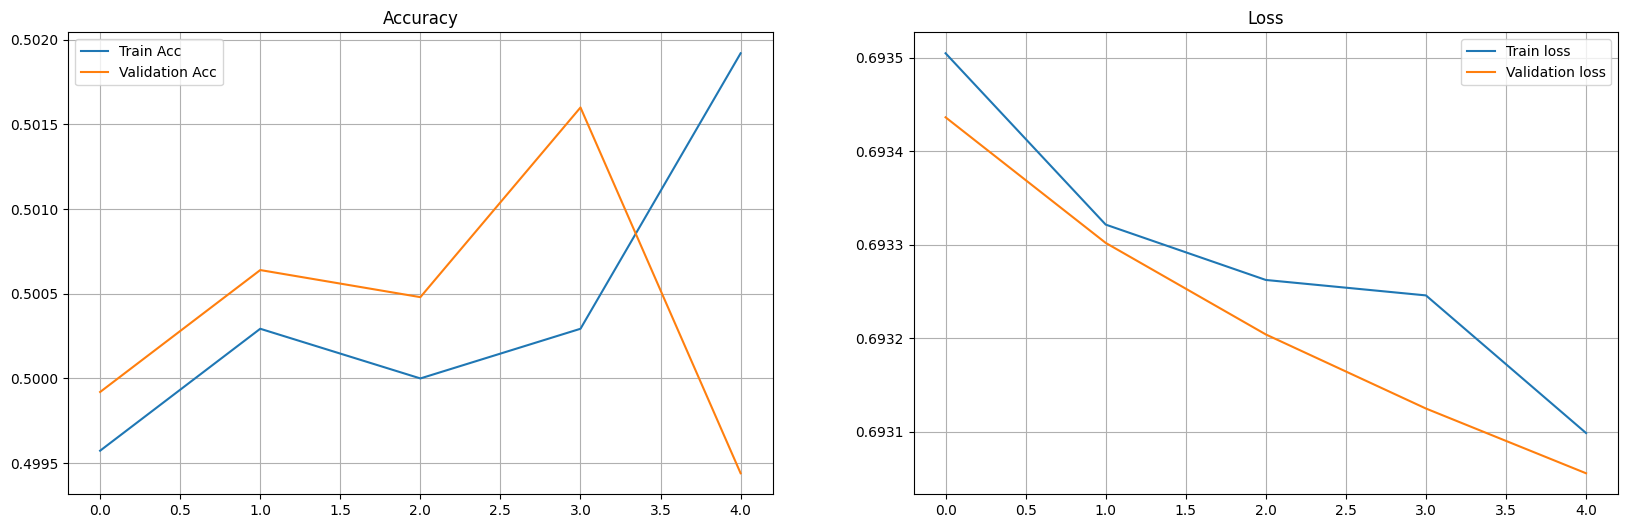

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()


In [ ]:
# Put your model in evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Loop through the test dataset to make predictions
with torch.no_grad():
    for inputs, labels in valid_loader:
        # Move inputs and labels to the device where your model is located
        inputs, labels = inputs.to(device), labels.to(device)

        # Initialize hidden state
        hidden = model.init_hidden(inputs.size(0))

        # Forward pass
        outputs, _ = model(inputs, hidden)

        # Convert outputs to binary predictions (0 or 1)
        predicted = torch.round(outputs).cpu().numpy()

        # Convert labels to numpy array and append to true_labels list
        true_labels.extend(labels.cpu().numpy())

        # Append predicted labels to predicted_labels list
        predicted_labels.extend(predicted)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
classes = ['positive', 'negative']
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')  # Save the confusion matrix as an image
plt.show()

NameError: ignored

#test loop for GRU

In [ ]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    t0 = time.time()
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = model.init_hidden(batch_size)

        model.zero_grad()
        output,h = model(inputs,h)
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = model.init_hidden(batch_size)

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy
            epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print('\nEpoch time: {} seconds'.format(time.time() - t0))
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '/content/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.692557335138321 val_loss : 0.6921388275623321
train_accuracy : 51.488 val_accuracy : 52.28

Epoch time: 43.4607310295105 seconds
Validation loss decreased (inf --> 0.692139).  Saving model ...
Epoch 2
train_loss : 0.6920847251415253 val_loss : 0.6912384397983551
train_accuracy : 51.861333333333334 val_accuracy : 53.664

Epoch time: 43.396520376205444 seconds
Validation loss decreased (0.692139 --> 0.691238).  Saving model ...
Epoch 3
train_loss : 0.6909311861197154 val_loss : 0.6903510837554931
train_accuracy : 53.168000000000006 val_accuracy : 54.535999999999994

Epoch time: 43.26146650314331 seconds
Validation loss decreased (0.691238 --> 0.690351).  Saving model ...
Epoch 4
train_loss : 0.6898908948898316 val_loss : 0.6894710128307342
train_accuracy : 54.186666666666675 val_accuracy : 55.584

Epoch time: 43.52604794502258 seconds
Validation loss decreased (0.690351 --> 0.689471).  Saving model ...
Epoch 5
train_loss : 0.6892185727755229 val_loss : 0.6885894672

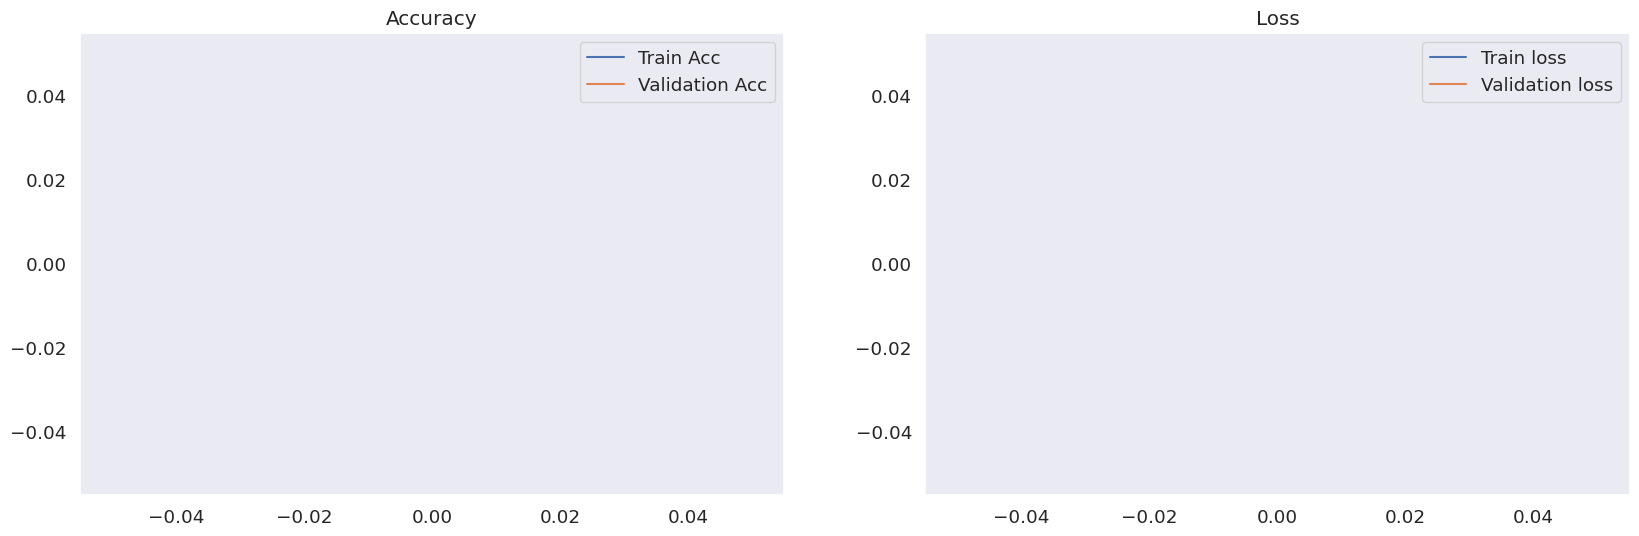

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()


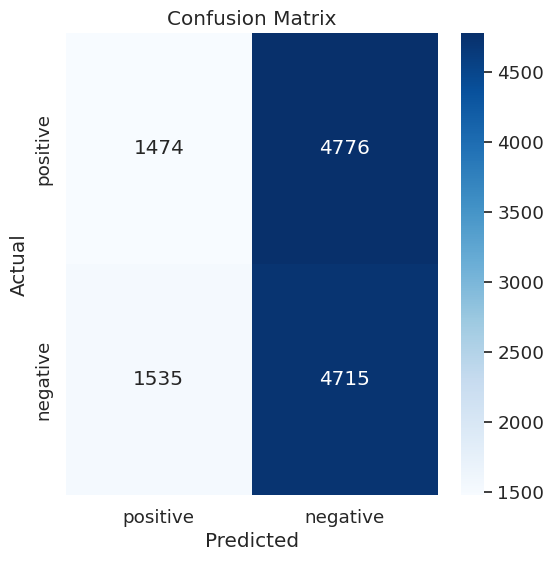

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming your test_loader contains the test data
# Assuming your model is loaded and named 'model'

# Put your model in evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Loop through the test dataset to make predictions
with torch.no_grad():
    for inputs, labels in valid_loader:
        # Move inputs and labels to the device where your model is located
        inputs, labels = inputs.to(device), labels.to(device)

        # Initialize hidden state
        hidden = model.init_hidden(inputs.size(0)).to(device)

        # Forward pass
        outputs, _ = model(inputs, hidden)

        # Convert outputs to binary predictions (0 or 1)
        predicted = torch.round(outputs).cpu().numpy()

        # Convert labels to numpy array and append to true_labels list
        true_labels.extend(labels.cpu().numpy())

        # Append predicted labels to predicted_labels list
        predicted_labels.extend(predicted)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
classes = ['positive', 'negative']
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')  # Save the confusion matrix as an image
plt.show()